In [20]:
import sqlglot
from sqlglot.expressions import Join, Condition, Column

# SQL view definition
sql = """
CREATE VIEW publication_overview AS
SELECT
    p.pid AS publication_id,
    p.title,
    p.abstract,
    p.year,
    p.citation_num,
    p.reference_num,

    a.aid AS author_id,
    a.name AS author_name,
    a.homepage AS author_homepage,

    o.name AS organization_name,
    o.continent AS organization_continent,

    d.did AS domain_id,
    d.name AS domain_name,

    k.kid AS keyword_id,
    k.keyword AS keyword_text,

    j.jid AS journal_id,
    j.name AS journal_name,

    c.cid AS conference_id,
    c.name AS conference_name

FROM publication p

JOIN writes w ON w.pid = p.pid
JOIN author a ON a.aid = w.aid

LEFT JOIN organization o ON a.oid = o.oid
LEFT JOIN domain_publication dp ON dp.pid = p.pid
LEFT JOIN domain d ON d.did = dp.did
LEFT JOIN publication_keyword pk ON pk.pid = p.pid
LEFT JOIN keyword k ON k.kid = pk.kid
LEFT JOIN journal j ON p.jid = j.jid
LEFT JOIN conference c ON p.cid = c.cid
"""

parsed = sqlglot.parse_one(sql)

joins = []

for join in parsed.find_all(Join):
    right = join.this.sql()

    condition = join.args.get("on")
    if condition:
        columns = condition.find_all(Column)
        col_pairs = [col.sql() for col in columns]

        if len(col_pairs) == 2:
            left_col, right_col = col_pairs
            joins.append({
                "left_table_column": left_col,
                "right_table_column": right_col,
                "right_table": right,
                "join_type": join.args.get("side", "INNER").upper()
            })

for join in joins:
    print(f"{join['join_type']} JOIN between:")
    print(f"  {join['left_table_column']} ⇄ {join['right_table_column']}  ({join['right_table']})")

INNER JOIN between:
  w.pid ⇄ p.pid  (writes AS w)
INNER JOIN between:
  a.aid ⇄ w.aid  (author AS a)
LEFT JOIN between:
  a.oid ⇄ o.oid  (organization AS o)
LEFT JOIN between:
  dp.pid ⇄ p.pid  (domain_publication AS dp)
LEFT JOIN between:
  d.did ⇄ dp.did  (domain AS d)
LEFT JOIN between:
  pk.pid ⇄ p.pid  (publication_keyword AS pk)
LEFT JOIN between:
  k.kid ⇄ pk.kid  (keyword AS k)
LEFT JOIN between:
  p.jid ⇄ j.jid  (journal AS j)
LEFT JOIN between:
  p.cid ⇄ c.cid  (conference AS c)


In [62]:
table_alias_mapping = {}
for table in parsed.find_all(Table):
    table_name = table.args['this'].sql()
    table_alias = table.args.get('alias', table_name)
    if type(table_alias)!=str:
        table_alias = table_alias.sql()
    table_alias_mapping[table_alias] = table_name

In [63]:
edges = []
for join in joins:
    left_table = table_alias_mapping[join['left_table_column'].split('.')[0]]
    left_col = join['left_table_column'].split('.')[1]
    
    right_table = table_alias_mapping[join['right_table_column'].split('.')[0]]
    right_col = join['right_table_column'].split('.')[1]

    join_col = f"{left_table}.{left_col} ⇄ {right_table}.{right_col}"
    edges.append((left_table, right_table, {'join_criteria':join_col, 'join_type':join['join_type']}))

C:\Users\91876\AppData\Local\Temp\ipykernel_12028\3819810406.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


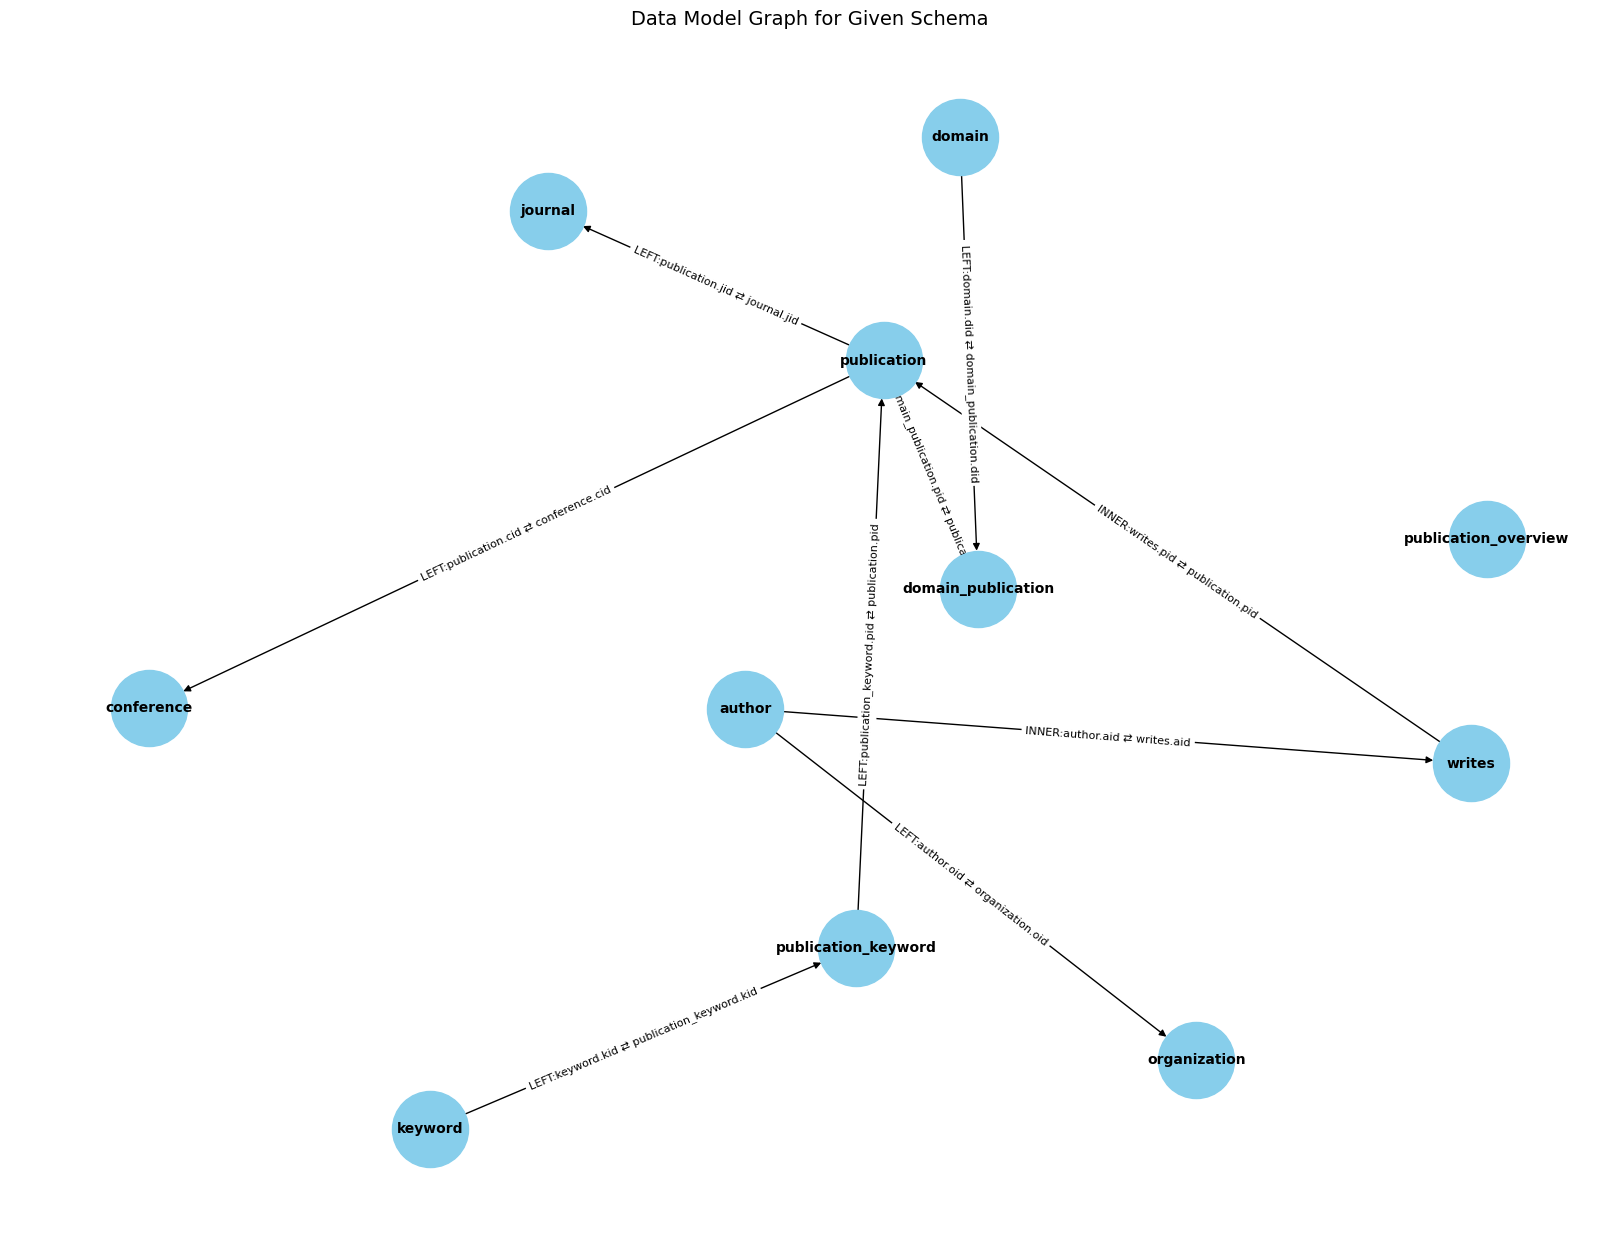

In [61]:
import networkx as nx
import matplotlib.pyplot as plt

tables = list(table_alias_mapping.values())

G = nx.DiGraph()

G.add_nodes_from(tables)
G.add_edges_from(edges)

edge_labels = {}
for u, v, data in G.edges(data=True):
    edge_labels[(u, v)] = f"{data['join_type']}:{data['join_criteria']}"

plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=1.5)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="#87CEEB", font_size=10, font_weight="bold", arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Data Model Graph for Given Schema", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

## Graph Analysis: Connected Components

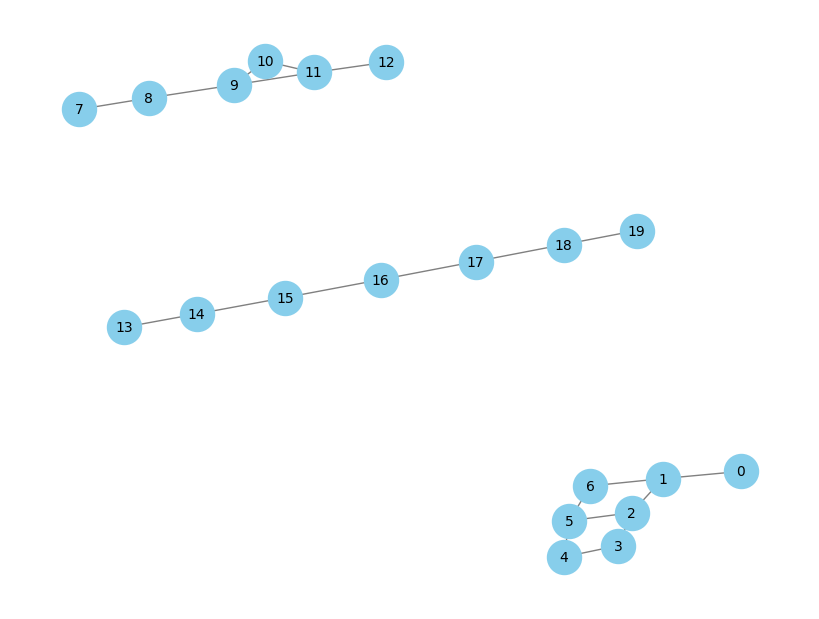

In [91]:
G = nx.Graph()

G.add_nodes_from(range(0, 7))
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (2,5), (1,6)])

G.add_nodes_from(range(7, 13))
G.add_edges_from([(7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (9,11)])

G.add_nodes_from(range(13, 20))
G.add_edges_from([(13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19)])

pos = nx.spring_layout(G, seed=25)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=600, font_size=10)
plt.savefig('bus_dom.jpg')
plt.show()


## Graph analysis: Shortest Paths

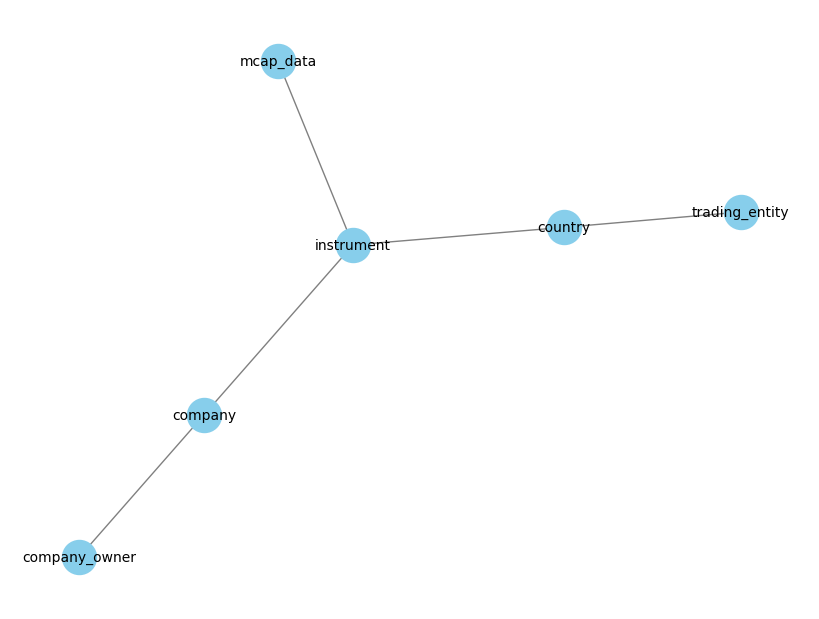

In [97]:
G = nx.Graph()

nodes = ['company','instrument','country','trading_entity', 'mcap_data', 'company_owner']
G.add_nodes_from(nodes)
G.add_edges_from([(nodes[0],nodes[1]), (nodes[1],nodes[2]),(nodes[2],nodes[3]), ('mcap_data','instrument'), ('company','company_owner')])

pos = nx.spring_layout(G, seed=25)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=600, font_size=10)

In [98]:
nl_query = "How many trading entities for company Reliance"
tables_needed = ['company','trading_entity']

shortest_path = nx.shortest_path(G, source=tables_needed[0], target = tables_needed[1])
shortest_path

['company', 'instrument', 'country', 'trading_entity']